In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.svm import SVC


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

import scipy.stats as stats

In [57]:
df = pd.read_csv('stock fundamental data.csv')
df.head()
len(df)

50560

# Preprocessing data


In [58]:
# check for any null values in market value 
df.isnull().sum()

gvkey          0
tic            0
fyear         51
indfmt         0
consol         0
popsrc         0
datafmt        0
curcd         51
act        21788
ap         10863
at          6722
ceq         6843
che        13777
cogs       13868
dlc         7086
dlcch      31465
dltt        6884
dp          9347
dvc         7149
ib          6821
intan       7427
invt       12160
ivao       15275
lct        21720
lt          6792
nopio      17628
ppent       8714
rect       14032
sale       13865
spi         7300
txp        15200
txt         6826
xad        35615
xido        6821
xint       12512
xrd        31021
xsga       19673
costat         0
mkvalt     14697
dtype: int64

In [59]:
#create column 'future mkvalt' that holds the market value of the next year
condition1 = df['tic'].shift(-1) == df['tic']
condition2 = df['fyear'].shift(-1) == df['fyear'] + 1
df['future_mkvalt'] = np.where(condition1 & condition2, df['mkvalt'].shift(-1), np.nan)

#drop nulls
df = df.dropna(subset=['mkvalt', 'future_mkvalt'], how='all')

#percent change is the percent change in market value from one year to the next
df['percent_change'] = (df['future_mkvalt']-df['mkvalt'])/df['mkvalt']

#if percent change is greater than 20%, classify as undervalued
df['undervalued'] = (df['percent_change'] > 0.10)

In [60]:
#fill null expenses with 0
df['xrd'] = df['xrd'].fillna(0)
df['xad'] = df['xad'].fillna(0)
df['xsga'] = df['xsga'].fillna(0)
df['xint'] = df['xint'].fillna(0)
df['dlcch'] = df['dlcch'].fillna(0)



#combine all expenses columns into one column
expenses_list = ['xrd', 'xad', 'xsga', 'xint', 'nopio', 'cogs']
df['expenses'] = df[expenses_list].sum(axis=1)

df = df.drop(columns=expenses_list)

#delete duplicate rows due to formatting
condition = df['indfmt'] != "FS"
df = df[condition]

#drop unneccessary columns
df = df.drop(columns=['indfmt', 'consol', 'popsrc', 'datafmt', 'curcd', 'gvkey', 'costat'])




In [61]:
df.isnull().sum()

tic                  0
fyear                0
act               7179
ap                 277
at                  98
ceq                154
che                 99
dlc                102
dlcch                0
dltt               231
dp                1619
dvc                251
ib                 158
intan              538
invt               459
ivao              1468
lct               7119
lt                 148
ppent             1258
rect               309
sale               157
spi                525
txp               4285
txt                163
xido               159
mkvalt            1742
future_mkvalt     4277
percent_change    6019
undervalued          0
expenses             0
dtype: int64

In [62]:
#remove rows with null values
condition = df.isnull().sum(axis=1) < 1
df = df[condition]

In [63]:
df.head(20)

,tic,fyear,act,ap,at,ceq,che,dlc,dlcch,dltt,...,sale,spi,txp,txt,xido,mkvalt,future_mkvalt,percent_change,undervalued,expenses
0,AIR,2009.0,863.429,114.906,1501.042,746.906,79.370,100.833,-4.996,336.191,...,1352.151,-4.302,3.263,20.986,0.000,777.8348,1049.8206,0.349670,True,1243.600
1,AIR,2010.0,913.985,185.096,1703.727,835.845,57.433,114.075,54.991,329.802,...,1775.782,-1.536,0.000,35.364,-3.313,1049.8206,485.2897,-0.537740,False,1613.484
2,AIR,2011.0,1063.272,201.405,2195.653,864.649,67.720,122.865,0.000,669.489,...,2074.498,-13.864,0.000,25.480,0.000,485.2897,790.0029,0.627900,True,1891.119
3,AIR,2012.0,1033.700,149.300,2136.900,918.600,75.300,86.400,0.000,622.200,...,2167.100,-21.100,0.000,26.700,0.000,790.0029,961.3080,0.216841,True,1970.300
4,AIR,2013.0,1116.900,171.100,2199.500,999.500,89.200,69.700,10.000,564.300,...,2035.000,0.000,0.000,32.100,0.000,961.3080,1046.3954,0.088512,False,1824.100
5,AIR,2014.0,954.100,142.300,1515.000,845.100,54.700,69.000,-80.000,85.000,...,1594.300,-48.400,0.000,-28.500,64.700,1046.3954,842.5112,-0.194844,False,1537.300
6,AIR,2015.0,873.100,163.400,1442.100,865.800,31.200,12.000,60.000,136.100,...,1662.600,-0.400,1.100,18.800,7.200,842.5112,1200.3288,0.424704,True,1531.800
7,AIR,2016.0,888.500,177.400,1504.100,914.200,10.300,2.000,21.000,155.300,...,1767.600,2.600,12.300,24.100,6.300,1200.3288,1551.4580,0.292528,True,1624.700
8,AIR,2017.0,942.700,170.000,1524.700,936.300,41.600,0.000,-1.000,177.200,...,1748.300,0.000,0.000,3.500,-58.100,1551.4580,1046.7709,-0.325299,False,1628.900
11,AAL,2011.0,6757.000,1007.000,23848.000,-7111.000,4739.000,1518.000,0.000,6702.000,...,24022.000,-886.000,0.000,0.000,0.000,117.3438,266.5571,1.271591,True,24332.000


In [64]:
# check for any null values
df.isnull().sum()

tic               0
fyear             0
act               0
ap                0
at                0
ceq               0
che               0
dlc               0
dlcch             0
dltt              0
dp                0
dvc               0
ib                0
intan             0
invt              0
ivao              0
lct               0
lt                0
ppent             0
rect              0
sale              0
spi               0
txp               0
txt               0
xido              0
mkvalt            0
future_mkvalt     0
percent_change    0
undervalued       0
expenses          0
dtype: int64

In [65]:
# new length of df after processing
len(df)

18538

# remove outliers

In [66]:
def remove_outliers_by_z_score(df):
    original_columns = df.columns

    target_cols = list(df.drop(columns = ["fyear", "undervalued","tic"]).columns)

    z_score_cols = []

    # Loop through our target columns
    for col in target_cols:
        # Make the new column name the same as the original but with 'z_score' added to it
        new_col_name = col + "_zscore"

        # Set the new column equal to the score
        df[new_col_name] = stats.zscore( df[col] )

        # Set the z-score to its absolute value of the for easier filtering
        df[new_col_name] = abs( df[new_col_name] )

        # Append the new column name our our z_score_cols list for easier access for later.
        z_score_cols.append(new_col_name)


    condition = df[z_score_cols] < 3
    print(df.shape)

    # # Say TRUE only if all of the rows are True, else return False
    condition = condition.all(axis=1)

    print('Before removal of outliers', df.shape)

    df = df[condition]

    print('After removal of outliers', df.shape)
    
    #keep original columns only
    df = df[original_columns]
    return df

Text(0.5, 0, 'Percent Increase in market value over 1 year period')

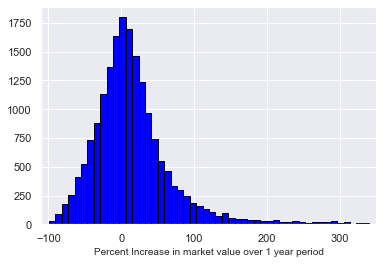

In [67]:
binwidth=0.1
    
# Set up the plot
plot = plt.subplot(1, 1, 1 )
    
# Draw the plot
plot.hist(df['percent_change']*100, bins = int(180/binwidth),
             color = 'blue', edgecolor = 'black')
    
    # Title and labels
plt.xlim(-110, 350)
plot.set_xlabel('Percent Increase in market value over 1 year period', size = 10)

In [68]:
#remove outliers
condition1 = df['percent_change'] < 1
df = df[condition1].reset_index()
df = df.drop(columns= ['index'])

Text(0.5, 0, 'Percent Increase in market value over 1 year period')

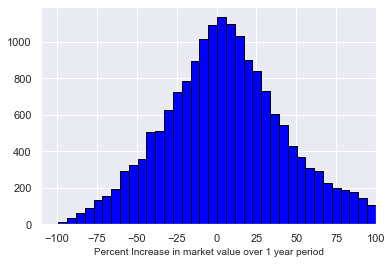

In [69]:
#replot
binwidth=5
    
# Set up the plot
plot = plt.subplot(1, 1, 1 )
plot.hist(df['percent_change']*100, bins = int(180/binwidth),
             color = 'blue', edgecolor = 'black')
    
#Title and labels
plt.xlim(-110, 100)
plot.set_xlabel('Percent Increase in market value over 1 year period', size = 10)

# Feature engineering

In [70]:
#feature selection 
from sklearn.feature_selection import SelectKBest, f_classif,f_regression

#features and predict value
Features = list(df.drop(columns=['tic', 'fyear', 'undervalued','percent_change','future_mkvalt']).columns)
X = df[Features]
y = df['future_mkvalt']

#find best features 
fs = SelectKBest(score_func=f_regression)

X_selected = fs.fit_transform(X,y)

In [71]:
# best features according to pearson test 
selected_features = fs.get_feature_names_out()
X = df[selected_features]
print(selected_features)

['act' 'at' 'ceq' 'che' 'dp' 'dvc' 'ib' 'lct' 'lt' 'mkvalt']


In [72]:
#print values of the features
fs.scores_

array([3.73457375e+04, 7.36457222e+03, 2.42191650e+04, 2.60811445e+04,
       2.96071245e+04, 4.36701394e+03, 7.91020421e+00, 8.60951883e+03,
       1.17489656e+04, 1.95125909e+04, 2.78053866e+04, 6.79249692e+03,
       3.35680561e+03, 4.12076310e+03, 1.82364480e+04, 1.52848687e+04,
       4.86567380e+03, 1.13985541e+04, 1.01542718e+04, 1.04780012e+03,
       4.82440048e+03, 1.14118974e+04, 9.12846792e+01, 4.23990772e+05,
       8.60000637e+03])

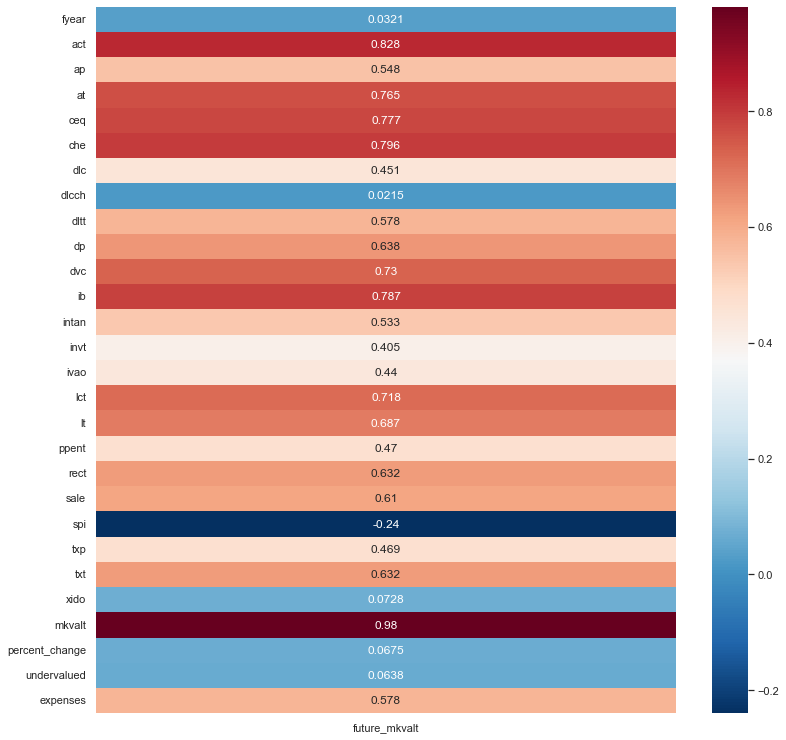

In [73]:
#create heatmap showing which values correlate most with undervalued helps select features

def create_corr_matrix(column_name):
    corr_mat = df.corr()

    corr_targ = corr_mat[[column_name]].drop(labels=[column_name])
    fig, ax = plt.subplots(figsize = (13,13))
    sns.heatmap(corr_targ, annot= True, fmt='.3',cmap='RdBu_r')
    plt.show()
    

create_corr_matrix("future_mkvalt")

# Functions for model evaluation and building 

In [74]:
# build pipline which evaluates models 
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
def build_and_eval_regression_model(model,X,y):
    print("running model report",model)
    
# Create training and test set from data 
# split training and testing data like this so no data leakage
    X_train = X.iloc[3800:]
    X_test = X.iloc[:3800]
    y_train = y.iloc[3800:]
    y_test = y.iloc[:3800]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model.fit(X_train_scaled,y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    r_squared = r2_score(y_test,y_pred)
    print("R-squared score:",r_squared)
    
    mea = mean_absolute_error(y_test,y_pred)
    print("\nMean Absolute Error:",mea)
    
    mse = mean_squared_error(y_test,y_pred)
    
    print("\nMean squared Error:",mse)
    return y_pred

In [75]:
# choose model and hyperparameters then run a grids search to find best paramaters
X_train = X.iloc[3800:]
X_test = X.iloc[:3800]
y_train = y.iloc[3800:]
y_test = y.iloc[:3800]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

DT_model = DecisionTreeRegressor()



params = {
        'max_depth': [3,5,7],
        'min_samples_leaf': [5,10, 25],
        'min_samples_split': [8, 10, 12],
        'max_features' : [2,6,8,None]
          }

gs = GridSearchCV(estimator=DT_model,
                      param_grid=params,cv=3,verbose=2,
                      refit=True,return_train_score=False)

gs.fit(X_train_scaled, y_train)
gs.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples

[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=

[CV] END max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END max_depth=5, max_features=8, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END max_depth=5, max_features=8, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END max_depth=5, max_features=8, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END max_depth=5, max_features=8, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV

[CV] END max_depth=7, max_features=6, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END max_depth=7, max_features=6, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV

{'max_depth': 7,
 'max_features': 8,
 'min_samples_leaf': 5,
 'min_samples_split': 12}

In [76]:
#convert predicted percent changes into undervalued or overvalued 
def undervalued(prediction):
    percent_change = (prediction - X_test['mkvalt'])/ X_test['mkvalt']
    arr = np.where(percent_change > .10,True,False)
    return arr

In [77]:
# Evaluate and print model scores using accuracy, precision, recall, f1 scores 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
def test_regression_conversion(model,undervalued_y_test,undervalued_y_pred):
    
    print("running test for model",model)
    accuracy = accuracy_score(undervalued_y_test,undervalued_y_pred)
    print("\nAccuracy Score: %f" % accuracy)

    precision = precision_score(undervalued_y_test,undervalued_y_pred)
    print("Precision Score: %f" % precision)

    recall = recall_score(undervalued_y_test,undervalued_y_pred)
    print("Recall Score: %f" % recall)

    f1 = f1_score(undervalued_y_test,undervalued_y_pred)
    print('F1 Score: %f' % f1)

In [78]:
# find the total return if you would invest in certain companies 
def find_return(model,y_test,undervalued_y_pred):
    undervalued_y_pred = undervalued_y_pred.tolist()
    gains = 0
    investment = 0
    arr = y_test.index
    len(arr)
    for i in range(len(undervalued_y_pred)):
        if(undervalued_y_pred[i]):
            index = arr[i]
            investment = investment + 100
            change = 100  + 100 * (df.loc[[index]]['percent_change'].values)
            gains = gains + change
            
#     convert gains to list so we can remove the value for formatting
    if model != DecisionTreeRegressor():
        gains = gains.tolist()
        gains = gains[0]
    
    
    percent_increase = (gains - investment)/investment      
    print("\nreturn for model",model)
    print('Initial Investment: ${investment: .2f}'.format(investment = investment))
    print('Total Return: ${gains: .2f}' .format(gains=gains))
    print('Percent increase: {percent_increase: .2f}'.format(percent_increase= percent_increase))  
   

# Build and Evaluate Regression models 

In [95]:
# train model using best parameters then test scores
rf = RandomForestRegressor(max_depth=7, max_features=None, min_samples_leaf=5,
                           min_samples_split=10, n_estimators=100)
y_pred_rf = build_and_eval_regression_model(rf,X,y)

running model report RandomForestRegressor(max_depth=7, max_features=None, min_samples_leaf=5,
                      min_samples_split=10)
R-squared score: 0.9412632148419701

Mean Absolute Error: 2888.516830723277

Mean squared Error: 96400770.06105563


In [80]:
# linear regression
lr = LinearRegression()
y_pred_lr = build_and_eval_regression_model(lr,X,y)

running model report LinearRegression()
R-squared score: 0.9438018952028705

Mean Absolute Error: 3002.577943041648

Mean squared Error: 92234203.21421112


In [90]:
# Knn Regressor 
k = 3
knnreg = KNeighborsRegressor(n_neighbors= k )
y_pred_kn = build_and_eval_regression_model(knnreg,X,y)

running model report KNeighborsRegressor(n_neighbors=3)
R-squared score: 0.8233283094455454

Mean Absolute Error: 5128.485169605263

Mean squared Error: 289959468.69777936


In [92]:
#decision tree regressor
dt = DecisionTreeRegressor(max_depth=7, max_features=8, min_samples_leaf=5,
                      min_samples_split=12)
y_pred_dt = build_and_eval_regression_model(dt,X,y)

running model report DecisionTreeRegressor(max_depth=7, max_features=8, min_samples_leaf=5,
                      min_samples_split=12)
R-squared score: 0.8930290682923336

Mean Absolute Error: 3429.7498200439263

Mean squared Error: 175564259.48446485


# Convert Predictions to categorical data and evaluate model

models prediction is converted to categorical data and is then evaluated. We then run the find return function to find what your gains would be if you would invest in the stocks that our model predicted as undervalued 

In [96]:
# gloabl y test set converted to true or false for testing
undervalued_y_test = undervalued(y_test)

In [97]:
# random forest test and returns 
undervalued_y_pred_rf = undervalued(y_pred_rf)

# test conversion 
test_regression_conversion(rf,undervalued_y_test,undervalued_y_pred_rf)

# find returns 
find_return(rf,y_test,undervalued_y_pred_rf)

running test for model RandomForestRegressor(max_depth=7, max_features=None, min_samples_leaf=5,
                      min_samples_split=10)

Accuracy Score: 0.518158
Precision Score: 0.449956
Recall Score: 0.295693
F1 Score: 0.356867

return for model RandomForestRegressor(max_depth=7, max_features=None, min_samples_leaf=5,
                      min_samples_split=10)
Initial Investment: $ 112900.00
Total Return: $ 122435.75
Percent increase:  0.08


In [98]:
# linear regression test and returns 
undervalued_y_pred_lr = undervalued(y_pred_lr)

# test convesrion 
test_regression_conversion(lr,undervalued_y_test,undervalued_y_pred_lr)

# find returns 
find_return(lr,y_test,undervalued_y_pred_lr)

running test for model LinearRegression()

Accuracy Score: 0.517632
Precision Score: 0.433217
Recall Score: 0.217113
F1 Score: 0.289259

return for model LinearRegression()
Initial Investment: $ 86100.00
Total Return: $ 92195.33
Percent increase:  0.07


In [99]:
# k nearest test and returns 

undervalued_y_pred_kn = undervalued(y_pred_kn)

# test conversion
test_regression_conversion(knnreg,undervalued_y_test,undervalued_y_pred_kn)

# find returns 
find_return(knnreg,y_test,undervalued_y_pred_kn)

running test for model KNeighborsRegressor(n_neighbors=3)

Accuracy Score: 0.519211
Precision Score: 0.467501
Recall Score: 0.456345
F1 Score: 0.461856

return for model KNeighborsRegressor(n_neighbors=3)
Initial Investment: $ 167700.00
Total Return: $ 183361.89
Percent increase:  0.09


In [100]:
# decision tree test and returns 

undervalued_y_pred_dt = undervalued(y_pred_dt)
# test conversion 
test_regression_conversion(dt,undervalued_y_test,undervalued_y_pred_dt)

# find returns 
find_return(dt,y_test,undervalued_y_pred_dt)

running test for model DecisionTreeRegressor(max_depth=7, max_features=8, min_samples_leaf=5,
                      min_samples_split=12)

Accuracy Score: 0.488684
Precision Score: 0.435159
Recall Score: 0.439464
F1 Score: 0.437301

return for model DecisionTreeRegressor(max_depth=7, max_features=8, min_samples_leaf=5,
                      min_samples_split=12)
Initial Investment: $ 173500.00
Total Return: $ 187386.44
Percent increase:  0.08
